In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, colors
from matplotlib.cbook import boxplot_stats
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from scipy import stats

In [2]:
df = pd.read_csv("./datos/heart.csv")

In [3]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Análisis multivariante

Seleccionamos las variables numéricas, para realizar una análisis multivariante de valores atípicos 

In [4]:
features = ["trtbps","chol","age","thalachh"]

## Boxplot

Visualizamos los graficos de caja para tener una referencia monovariante de los valores atípicos extraidos estadísticamente.

<AxesSubplot: >

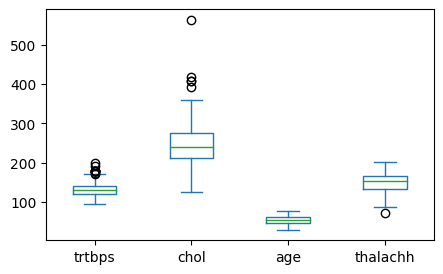

In [5]:
df[features].plot.box(figsize=(5,3))

Imprimimos los valores atípicos

In [6]:
stats_boxplot = list(zip(features, boxplot_stats(df[features])))

[print(feature, stats["fliers"]) for feature, stats in stats_boxplot]

trtbps [172 178 180 180 200 174 192 178 180]
chol [417 564 394 407 409]
age []
thalachh [71]


[None, None, None, None]

Una vez tenemos los valores de referencia, vamos a clusterizar los datos según las cuatro variables numéricas y confirmar si todos ellos son realmente valores atípicos en un espacio de variables multidimensional.

## Reachability Plot

Escalamos los datos primero

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaled = MinMaxScaler().fit_transform(df[features])

df_scaled = pd.DataFrame(scaled, columns=features)

Ejecutamos OPTICS para extraer los clusters de los datos a través de un gráfico de alcanzabilidad

Number of clusters:  7


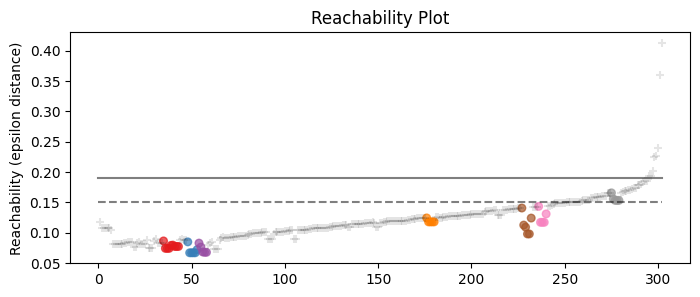

In [8]:
clust= OPTICS().fit(df_scaled)

space = np.arange(len(df_scaled))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

# Normalización de las etiquetas para obtener los colores de los clusters
norm = colors.Normalize(vmin=0, vmax=max(labels))

plt.figure(figsize=(8, 3))

# Plot datos normales
plt.scatter(space[labels!=-1], reachability[labels!=-1], c=labels[labels!=-1], norm=norm, s=30, cmap="Set1", alpha=.7)
# Plot atipicos
plt.scatter(space[labels==-1], reachability[labels==-1], c="black", s=30, alpha=.1, marker="+")

# Lineas de corte de extracción eps
plt.plot(space, np.full_like(space, .15, dtype=float), "k--", alpha=0.5)
plt.plot(space, np.full_like(space, .19, dtype=float), "k-", alpha=0.5)

plt.ylabel("Reachability (epsilon distance)")
plt.title("Reachability Plot")

print("Number of clusters: ",labels.max()+1)

Situamos dos lineas de corte para la extracción de los clusters. Una por encima del último cluster en la que la pendiente de los atipicos se vuelve más empinada (donde sólo analizaremos los datos atípicos mas solitarios) y otra justo por debajo del último cluster, para poder comparar los atípicos que extraemos asumiendo que el último cluster es ya extraño.

Extraemos los atípicos para las dos líneas de corte

In [9]:
def extract_cluster_dbscan_eps(eps):
    labels = cluster_optics_dbscan(
        reachability=clust.reachability_,
        core_distances=clust.core_distances_,
        ordering=clust.ordering_,
        eps=eps
    )
        
    return labels

In [10]:
labels_15 = extract_cluster_dbscan_eps(.15)
labels_19 = extract_cluster_dbscan_eps(.19)

df["atipico_15"] = labels_15==-1
df["atipico_19"] = labels_19==-1

print("Number of clusters atipico_15: ",labels_15.max()+1)
print("Number of clusters atipico_19: ",labels_19.max()+1)

Number of clusters atipico_15:  1
Number of clusters atipico_19:  1


### Análisis **trtbps**

In [11]:
def print_atipicos(feature, f_pos):
    print("\n atipico boxplot: ",sorted(list(stats_boxplot[f_pos][1]["fliers"]),reverse=True))
    print("\n atipico_cluster_eps_19: ",df.loc[df.atipico_19,feature].sort_values(ascending=False).values)
    print("\n atipico_cluster_eps_15: ",df.loc[df.atipico_15,feature].sort_values(ascending=False).values)

In [12]:
print_atipicos("trtbps", 0)


 atipico boxplot:  [200, 192, 180, 180, 180, 178, 178, 174, 172]

 atipico_cluster_eps_19:  [200 192 164 160 140 125 120 115]

 atipico_cluster_eps_15:  [200 192 180 180 180 178 178 174 170 170 170 170 165 164 160 160 160 160
 152 150 150 150 142 140 140 140 140 140 136 134 132 132 130 130 125 120
 120 120 120 120 120 115 114 112 110 110 110 110 102 100 100]


Comparando los atípicos del boxplot y los del cluster con eps 19, vemos que los 180 no están incluidos en el cluser eps 19, así como los 170s. Sin embargo, si los vemos en el cluster eps 15 (que recordemos incluye como outliers los datos del ultimo cluster del Reachability plot). 

Nuestra propuesta sería eliminar el minimo común múltipo de los tres (valores 200 y 192) e imputar por KNN los dos valores eliminados.

### Análisis **chol**

In [13]:
print_atipicos("chol", 1)


 atipico boxplot:  [564, 417, 409, 407, 394]

 atipico_cluster_eps_19:  [564 360 321 304 288 283 237 176]

 atipico_cluster_eps_15:  [564 417 409 407 360 353 341 327 326 325 322 321 318 315 311 304 302 302
 299 298 289 289 288 288 283 275 274 274 270 269 265 265 249 248 243 239
 237 228 227 225 211 204 198 197 178 177 176 167 164 149 126]


Sucede lo mismo que con la variable *trtbps*. Solo el valor más extremo (564) se encuentra en los tres grupos de atípicos. Los valores de 400s aparecen en el grupo de eps 15 porque, según el gráfico de alcanzabilidad, representen un cluster de datos bien definido y no son outliers al realizar un análisis multivariante.

La propuesta es la misma que antes. Eliminar el minimo común múltipo de los tres (valores 564) e imputar por KNN el valor eliminado.

### Análisis **Age**


In [14]:
print_atipicos("age", 2)


 atipico boxplot:  []

 atipico_cluster_eps_19:  [77 67 67 65 59 56 54 39]

 atipico_cluster_eps_15:  [77 76 74 71 71 71 70 68 68 67 67 67 66 66 65 65 64 64 63 62 60 59 59 59
 59 59 58 58 58 57 57 57 56 56 55 55 55 54 54 51 50 47 46 46 43 42 42 40
 39 35 29]


La edad no tiene atípicos estadísticos, de manera que no eliminamos datos

### Análisis **thalachh**

In [15]:
print_atipicos("thalachh", 3)


 atipico boxplot:  [71]

 atipico_cluster_eps_19:  [195 182 162 160 151 133  90  71]

 atipico_cluster_eps_15:  [202 195 182 173 165 162 162 160 160 159 157 155 154 154 151 151 150 150
 146 145 145 145 143 140 140 136 133 132 130 130 128 126 125 125 125 124
 122 122 122 121 120 118 117 116 115 114 109  96  90  88  71]


Como en los casos anteriores, el atípico común a los tres grupos es el valor 71.

Proponemos eliminarlo e imputar por KNN

## Analisis estadistico entre dos grupos

Las variables que vamos a analizar son:

- sex (sexo)
- trtbps (presión sanguinea en reposo)
- chol (colesterol en sangre

Con el fin de determinar si las variables *trtbps* y *chol* son candidatas a predecir una mayor probabilidad de ataque al corazón, vamos a determinar si el *sexo* es un factor que afecta a una **diferenciacion estadística** en ambas variables, de manera que nos debamos plantear analizarlas de manera separada para ambos sexos, a nivel de análisis de **Correlación** y **Regresión**.

Para ello, vamos a realizr pruebas estadísticas entre los dos grupos de sexo y las variables numéricas:

In [56]:
from scipy.stats import boxcox, shapiro, ttest_ind, levene, mannwhitneyu

Normalizamos las variables numéricas

In [30]:
trtbps_norm = boxcox(df.trtbps)[0]
chol_norm = boxcox(df.chol)[0]

Test de normalidad

In [38]:
print(shapiro(trtbps_norm))
print(shapiro(chol_norm))

ShapiroResult(statistic=0.9911395907402039, pvalue=0.06516099721193314)
ShapiroResult(statistic=0.9928725957870483, pvalue=0.1582442671060562)


Ambas variables siguen distribución normal

Test de homocedasticidad

In [45]:
print(levene(trtbps_norm[df.sex==1], trtbps_norm[df.sex==0]))
print(levene(chol_norm[df.sex==1], chol_norm[df.sex==0]))

LeveneResult(statistic=1.0659285626419608, pvalue=0.3026957228820938)
LeveneResult(statistic=5.713023019522199, pvalue=0.017454338440968237)


Existe homocedasticidad en la variable *trtbps*, pero no en *chol*. Aplicaremos test paramétrico para la primera y no paramétrico para la segunda.

Test t-student

In [46]:
print(ttest_ind(trtbps_norm[df.sex==1], trtbps_norm[df.sex==0]))

Ttest_indResult(statistic=-0.7742151622061374, pvalue=0.43941124853507996)


No supera el test

Test Mann-Whitney

In [48]:
print(mannwhitneyu(chol_norm[df.sex==1], chol_norm[df.sex==0]))

MannwhitneyuResult(statistic=8070.0, pvalue=0.008555084861224024)


No supera el test

### Conclusion 

Las variables no pasan las pruebas T-Student y Mann-Whitney, de manera que podemos tratar las muestras respecto del sexo como si fueran de diferentes poblaciones, lo que nos lleva a realizar test estadísticos de Correlación y Regresión de manera independiente también.

## Regresión logística

Como parte de la fase de análisis de datos, queremos probar a realizar una aproximación a un modelo predictivo de la variable *output* a partir de una regresión logística, que nos permita estimar si son buenas candidatas a varibales predictoras. 

Dadas las conclusiones del análisis estadistico por sexo, vamos a realizar el modelo por separado.

In [59]:
from sklearn.linear_model import LogisticRegression

In [64]:
df_new = pd.DataFrame()
df_new["trtbps_norm"] = trtbps_norm
df_new["chol_norm"] = chol_norm

In [178]:
def predict_on_sex(sex):
    
    X = df_new[df.sex==sex]
    y = df.output[df.sex==sex]
    
    model = LogisticRegression().fit(X, y)
    
    y_pred = model.predict(df_new[df.sex==sex])    
    
    return X, y, y_pred, model

### Analisis sex=1

In [220]:
X, y, y_pred, model = predict_on_sex(1)

In [221]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, RocCurveDisplay

In [222]:
confusion_matrix(y, y_pred)

array([[109,   5],
       [ 90,   3]], dtype=int64)

In [223]:
precission = precision_score(y, y_pred)
print("Precission:",round(precission*100,1),"%")
recall = recall_score(y, y_pred)
print("Recall",round(recall*100,1),"%")

Precission: 37.5 %
Recall 3.2 %


El modelo tiene mucha tendencia a clasificar como negativo (109 True Negative y 90 False Negative). 

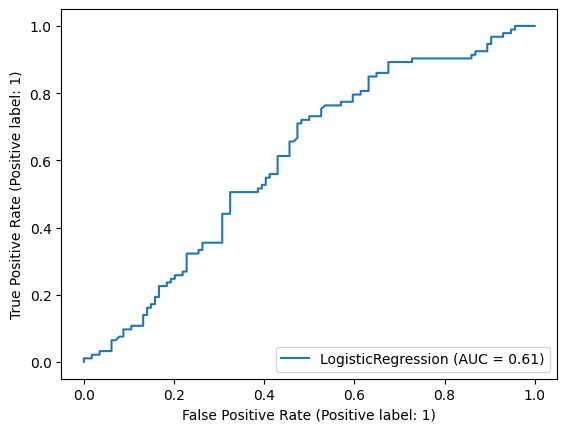

In [224]:
RocCurveDisplay.from_estimator(model, X, y)

### Analisis sex=0

In [225]:
X, y, y_pred, model = predict_on_sex(0)

confusion_matrix(y, y_pred)

array([[ 0, 24],
       [ 0, 72]], dtype=int64)

In [226]:
precission = precision_score(y, y_pred)
print("Precission:",round(precission*100,1),"%")
recall = recall_score(y, y_pred)
print("Recall",round(recall*100,1),"%")

Precission: 75.0 %
Recall 100.0 %


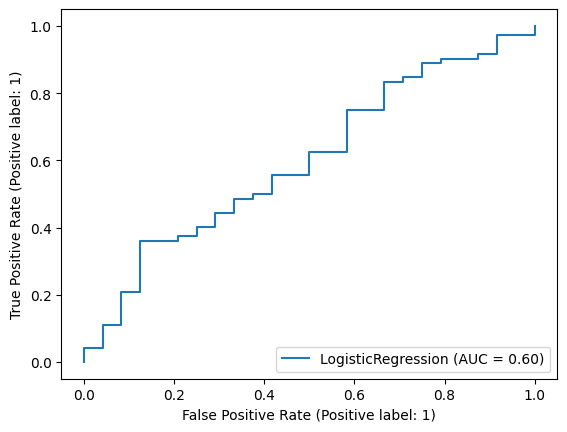

In [227]:
RocCurveDisplay.from_estimator(model, X, y)

<AxesSubplot: xlabel='sex,output'>

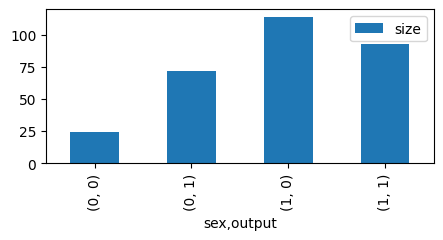

In [175]:
g = df.groupby(by=["sex","output"]).size().to_frame('size')
g.plot.bar(figsize=(5, 2))